In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, LegendreLoss, Metrics, find_threshold,DataSet
from models import find_threshold
torch.manual_seed(42)

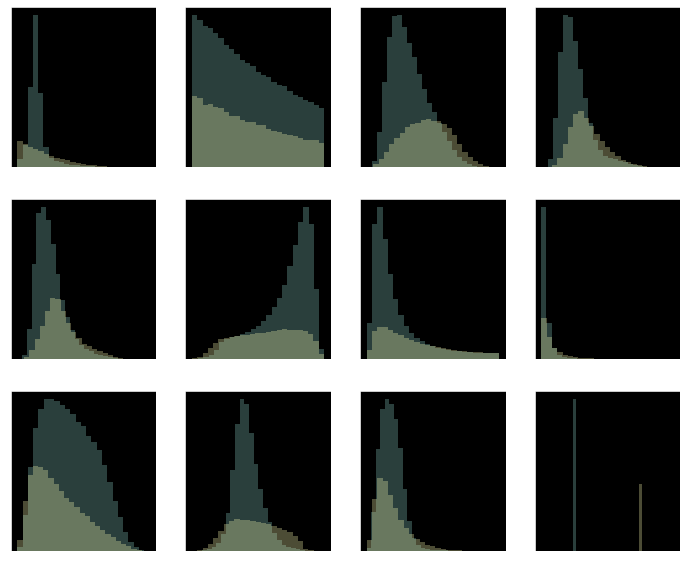

In [2]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"]
val = files["val"]

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3)
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3)
    ax.set_yticks([])

In [3]:
class weighted_mse():
    def __init__(self,labels):
        ones = sum(labels)
        self.ones_frac = ones/(labels.shape[0]-ones)
    def __call__(self,pred,target):
        weights = target/self.ones_frac + (1-target)
        return torch.mean(weights*(pred-target)**2)

In [4]:
params = {'epochs' : 2000,
          'interval'   : 100,
          'batch_size' : 1024,
          'shuffle'    : True,
          'num_workers': 6}
traindataset = DataSet(samples=train[::300,1:-1].astype(float),
                       labels=train[::300,-1].astype(int))
valdataset = DataSet(samples=val[:,1:-1].astype(float),
                     labels=val[:,-1].astype(int))
metrics_train = Metrics()
metrics_val = Metrics(validation=True)

In [8]:
model = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
criterion = weighted_mse(labels=traindataset.labels)
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params,
          optimizer= optimizer,
          loss=criterion,
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Entering Training...
Epoch:0100/2000 || Train: loss:0.3519, acc:68% || Test: loss: 0.4866, acc:74%, R50: 5.2381  || 07.4s
Epoch:0200/2000 || Train: loss:0.3157, acc:70% || Test: loss: 0.4357, acc:68%, R50: 5.3398  || 14.7s
Epoch:0300/2000 || Train: loss:0.2712, acc:71% || Test: loss: 0.4174, acc:67%, R50: 5.6995  || 22.1s
Epoch:0400/2000 || Train: loss:0.2728, acc:72% || Test: loss: 0.3920, acc:70%, R50: 6.4706  || 29.5s
Epoch:0500/2000 || Train: loss:0.2653, acc:74% || Test: loss: 0.3337, acc:75%, R50: 7.9710  || 37.0s
Epoch:0600/2000 || Train: loss:0.2795, acc:72% || Test: loss: 0.3508, acc:75%, R50: 9.4828  || 44.4s
Epoch:0700/2000 || Train: loss:0.2545, acc:74% || Test: loss: 0.3600, acc:75%, R50: 10.0917  || 51.8s
Epoch:0800/2000 || Train: loss:0.2786, acc:74% || Test: loss: 0.2740, acc:81%, R50: 11.9565  || 59.2s
Epoch:0900/2000 || Train: loss:0.2307, acc:78% || Test: loss: 0.3436, acc:75%, R50: 13.5802  || 66.6s
Epoch:1000/2000 || Train: loss:0.2553, acc:75% || Test: loss: 0.242